This report is to analyze the July transaction records of HOURCAR company which is a car rental company provides both short time period rental and long time period rental. Out goal is to find out some useful information that can help HOURCAR to increase its profit or to explore the possibilities for one-way approach.
I am using python 2.7.x to analyze the July dataset that contains 1675 rows and 51 columns.
We have two target variables, total cost and membership types. We will examine how the changes of other independent variabls affect the performance of these two target variables.
Typically, we will focus on solving the below quesiton:
a. Detailed travel pattern of each trip (distance traveled, time stopped, location of stops)

In [1]:
import gmplot             # plot the locations on google map
import numpy as np        # linear algebra
import pandas as pd       # data processing, CSV file I/O (e.g. pd.read_csv())
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns       # data visualization
import datetime        # process date and time objects

xls = pd.ExcelFile("August.xls")
train_df = xls.parse('Events') # Read the selected sheet by sheet name
train_df = pd.DataFrame(train_df) # Convert dataset to DataFrame that is easier to manipylate in futher analysis

print('Loading HOURCAR August dataset...')
print('HOURCAR August dataset shape: ')
print(train_df.shape)
print('HOURCAR August dataset data types: ')
print(train_df.dtypes)
print('The first few rows of HOURCAR August dataset : ')
print(train_df.head())
train_df_null = train_df.isnull().sum()
print('The ratio of missing values in each column : ')  
print(train_df_null/train_df.shape[0])



F:\Anaconda3\envs\gl-env\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Loading HOURCAR August dataset...
HOURCAR August dataset shape: 
(1675, 52)
HOURCAR August dataset data types: 
ID (Event)                                      int64
Event group                                    object
Event Type                                     object
Device                                         object
ID (Device)                                     int64
DeviceItemAccessType                           object
Item                                           object
ID (Item)                                       int64
ID (Person)                                     int64
Timestamp                              datetime64[ns]
received                               datetime64[ns]
received_copy                          datetime64[ns]
ID (Reservation)                                int64
Reservation                                     int64
ID (Customer)                                   int64
ID (Smart Card)                                 int64
card type               

The August data set looks pretty completed, so there is no need to deal with missing data. We can start the analysis by using the original data set. First, let's draw a heatmap for the longitudes and latitudes to see the travel path pattern.

In [2]:
# Rename the columns
train_df['Triggered_time'] = train_df['Timestamp']
train_df['Received_time'] = train_df['received']
train_df['GPS_Latitude'] = train_df['GPS Latitude']
train_df['GPS_Longitude'] = train_df['GPS Longitude']
train_df['Location_ID'] = train_df['ID (Location)']
train_df['City_ID'] = train_df['ID (City)']
train_df['Reservation_ID'] = train_df['ID (Reservation)']

In [3]:
columns = ['Triggered_time', 'Received_time','GPS_Latitude','GPS_Longitude','Reservation_ID','Location_ID','Location','City_ID','City']
train_august = pd.DataFrame(train_df, columns=columns)

In [4]:
# Draw a heatmap for the locations on google map
def plot_heat_map(data,number) :
    
    latitude_array = data['GPS_Latitude'].values
    latitude_list = latitude_array.tolist()

    Longitude_array = data['GPS_Longitude'].values
    longitude_list = Longitude_array.tolist()

    # Initialize the map to the first location in the list
    gmap = gmplot.GoogleMapPlotter(latitude_list[0],longitude_list[0],10)

    # gmap.scatter(latitude_list, longitude_list, edge_width=10)
    gmap.heatmap(latitude_list, longitude_list)

    # Write the map in an HTML file
    # gmap.draw('Paths_map.html')
    gmap.draw('{}_Paths_map.html'.format(number))


In [5]:
plot_heat_map(train_august,'1')

By analyzing the heatmap, we get an idea of the distribution of the travel paths. By zooming in the heatmap, we can find out which specific roads or streets have relatively more travel trips taken. This information can help HOURCAR to decide how far to set the one-way station or how many stations should be set in that road or street. We will provide more detailed information about the location of stops and time of stops in the following analysis.

Nicollet and Groveland                         186
Seven Corners Apartments                       120
Elliot Park - 15th St E and 11th Ave S         112
222 Hennepin - Hennepin and 2nd St N           111
Midtown Global Market - Lake and 11th Ave S    106
Dinkytown - 6th St SE and 13th Ave SE           95
Discovery Lot                                   93
Calhoun Square Ramp                             90
Uptown YWCA                                     68
Franklin and Dupont                             67
HUGE Improv Theater - 31st and Lyndale          59
Lowertown - 7th St E and Wall                   59
Intermedia Arts - 28th and Lyndale              56
Frontier Hall                                   56
Name: Location, dtype: int64


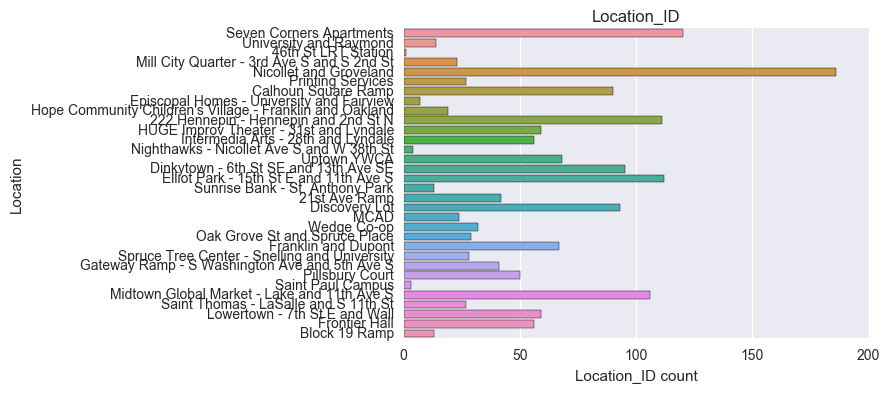

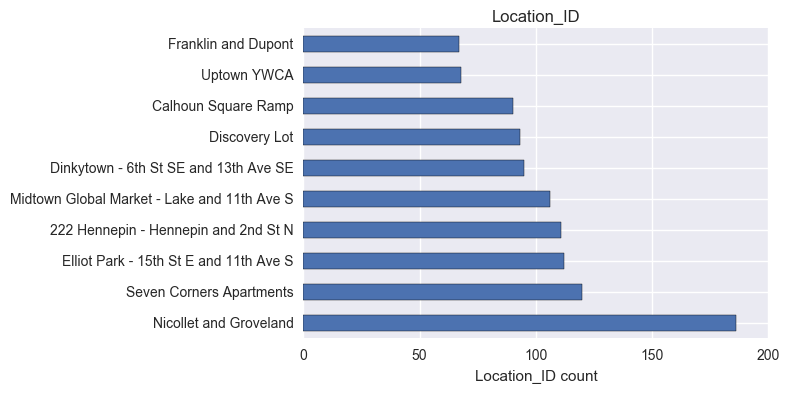

In [6]:
# Which locations has the most travel trips taken
L_cnt = train_august['Location'].value_counts()
print(L_cnt[L_cnt>50])
sns.countplot(y='Location', data=train_august)
# plt.xticks(rotation=45)
plt.xlabel('Location_ID count')
plt.title('Location_ID')
plt.show()

# Display the first ten locatons that have the most travel trips taken
ax = L_cnt.iloc[:10].plot(kind="barh")
plt.title('Location_ID')
plt.xlabel('Location_ID count')
plt.show()

We plot the number of travel trips in each location, some of the locations show a very low number of travel trips taken, so we will not analyze those locations now. Let's plot the first ten locatons that have the most travel trips taken. We can see that customers have the highest probability to travel to these locations : Nicollet and Groveland, Seven Corners Apartments, Elliot Park - 15th St E and 11th Ave S, 222 Hennepin - Hennepin and 2nd St N, Midtown Global Market - Lake and 11th Ave S, Dinkytown - 6th St SE and 13th Ave SE, Discovery Lot, Calhoun Square Ramp, Uptown YWCA and Franklin and Dupont.

We can further compute the distance between these locations to see which specific location in that road or street is suitable for building one-way station. But additional data is required for this analysis.

Now let's calculate the distance between each trip based on the latitudes and longitudes. Though the data recored according to continuous time, it is not for the same reservation. In order to analyze the location stops and time stops, we need to retrive the data for each location. But first, let's build the functions to compute the spherical distance between the travel locations, to calculate the time period for the distance and to plot the distrubution of the distances.

In [7]:
# calculate spherical distance between the travel locations
from math import sin, asin, cos, radians, fabs, sqrt  
   
EARTH_RADIUS=6371           # earth radius，6371km  
   
def hav(theta):  
    s = sin(theta / 2)  
    return s * s  
   
def get_distance_hav(lat0, lng0, lat1, lng1):  
    # convert latitude and longitude to radian  
    lat0 = radians(lat0)  
    lat1 = radians(lat1)  
    lng0 = radians(lng0)  
    lng1 = radians(lng1)  
   
    dlng = fabs(lng0 - lng1)  
    dlat = fabs(lat0 - lat1)  
    h = hav(dlat) + cos(lat0) * cos(lat1) * hav(dlng)  
    distance = 2 * EARTH_RADIUS * asin(sqrt(h))  
   
    return distance  
# the distance unit here is KM

In [8]:
def get_stop_time_interval(data) :
    
        TP_list = []
        data['Time_period'] = data['Received_time'] - data['Triggered_time']
        Time_period = data['Time_period']
#         print(Time_period)
        for elem in Time_period :
            if elem < datetime.timedelta(minutes=1) :
                TP_list.append('00:01:00')
            elif elem < datetime.timedelta(minutes=2) :
                TP_list.append('00:02:00')
            elif elem < datetime.timedelta(minutes=3) :
                TP_list.append('00:03:00')
            elif elem < datetime.timedelta(minutes=4) :
                TP_list.append('00:04:00')
            else :
                TP_list.append('00:05:00')
        
#         print(len(TP_list))
        data['Stop_Time_Interval'] = [elem for elem in TP_list]
#         print(TP_list)
        return data

In [9]:
def stop_time_interval_plot(data) :
    
    data = data[data['Distance']<0.1]
    
    sns.countplot(x='Stop_Time_Interval', data=data)
    plt.xticks(rotation=80)
    plt.xlabel('Stop_Time_Interval count')
    plt.title('Stop_Time_Interval')
    plt.show()

In [10]:
def stop_times_larger_than_three_mins(data) :
    
    data = data[data['Distance']<0.1]
    
    three_mins = datetime.timedelta(minutes=3)
    Time_period = data['Time_period']
    print(data[Time_period > three_mins])

In [11]:
def get_speed(data) :
#     print(data['Time_period'])
    data['Hour'] = data['Time_period'].astype('timedelta64[s]') / 3600
    data['Speed'] = data['Distance']  / data['Hour'] 
#     print(data['Hour'])
    
    return data

In [12]:
# Compute the distance by reservation id
def get_distance_by_rev_id(rev_id) :
    
        data1 = train_august[train_august['Reservation_ID'] == rev_id]

        new_dlist = []
        new_dlist.append(0) 
        latlist = data1['GPS_Latitude'].values.tolist()
        lonlist = data1['GPS_Longitude'].values.tolist()

        for i in range(0,len(latlist)-1) :
            latitude1 = latlist[i]
            latitude2 = latlist[i+1]
            longitude1 = lonlist[i]
            longitude2 = lonlist[i+1]
        
            distance = get_distance_hav(latitude1, longitude1, latitude2, longitude2)
            new_dlist.append(distance)
    
        # print(len(dlist))
        data1['Distance'] = [elem for elem in new_dlist]
    
        return data1

In [13]:
# Plot the distance distribution
def distance_distribution_plot(data) :
    
    sns.distplot(data.Distance.values, bins=50) #distribution plot
    plt.xlabel('Distance', fontsize=12)
    plt.show()
    
#     print()

In [14]:
def get_stop_time_interval_speed(data) :
    
        TP_list = []
        data['Time_period'] = data['Received_time'] - data['Triggered_time']
        Time_period = data['Time_period']
#         print(Time_period)
        for elem in Time_period :
            if elem < datetime.timedelta(minutes=4) :
                TP_list.append('00:03:00')
            elif elem < datetime.timedelta(minutes=5) :
                TP_list.append('00:04:00')
            else :
                TP_list.append('00:05:00')
        
#         print(len(TP_list))
        data['Stop_Time_Interval'] = [elem for elem in TP_list]
#         print(TP_list)
        return data

We compute the number of travel trips taken for each reservation, there are more than 20 reservations in this data set. But we will ananlyze the first three reservations at this monment.

As we can see from the Distribution plot of Distance, data has flat line between 0.0 to 0.2, so the data mgiht have some time stop at a certain location. The statistics indicates that there are four entries that have distance less than 0.1 KM, however, the stop time between these distances is too short ot be considered as stop time. 

As we can see from the Distribution plot of Distance, data has flat line between 0.0 to 0.2,so the data mgiht have some time stop at a certain location. The statistics indicates that there are eight entries that have distance less than 0.1 KM. However, the stop time between these distances is also too short ot be considered as stop time. 

For the third reservation, the situation is pretty the same as the previous two. The stop time between these distances is also too short ot be considered as stop time. 

In [15]:
# For the combination of each reservation
RID = train_august['Reservation_ID'].unique()
data = get_distance_by_rev_id(136685)
# data = get_stop_time_interval(data)
data = get_stop_time_interval_speed(data)
# print(data.dtypes)

df = pd.DataFrame(data)
# print(df)

for elem in RID :
    data = get_distance_by_rev_id(elem)
#     data = get_stop_time_interval(data)
    data = get_stop_time_interval_speed(data)
    data = get_speed(data)
#     print(data.shape)
    df = df.append(data)
#     print(df.shape)

F:\Anaconda3\envs\gl-env\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\envs\gl-env\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Anaconda3\envs\gl-env\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

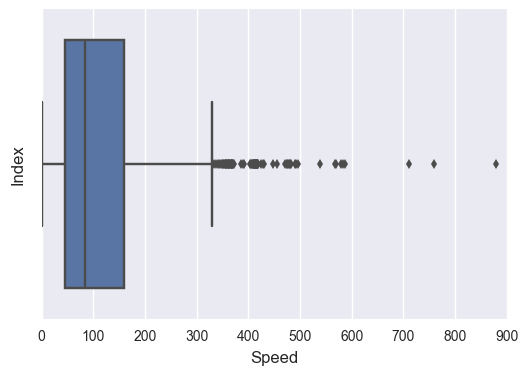

In [16]:
sns.boxplot(x=np.sort(df.Speed.values), data=df)
plt.xlabel('Speed', fontsize=12)
plt.ylabel('Index', fontsize=12)
plt.show()

# df = df.dropna()
# df['Speed'] = df['Speed'].astype(np.int64)
# print(df.Speed.values)
# sns.distplot(df.Speed.values,bins=30) #distribution plot
# plt.xlabel('Speed', fontsize=12)
# plt.show()

In [17]:
df = df.dropna()
print(df['Speed'].describe())

count    1675.000000
mean             inf
std              NaN
min         0.000000
25%        44.729506
50%        83.957446
75%       158.550810
max              inf
Name: Speed, dtype: float64


In [18]:
# print(df)
df = df[df['Speed'] < 5]
columns = ['Location_ID','Location','City_ID','City','Speed','Stop_Time_Interval']
print(df[columns])

      Location_ID                                           Location  City_ID  \
0              19                           Seven Corners Apartments       20   
324            19                           Seven Corners Apartments       20   
356            19                           Seven Corners Apartments       20   
362            19                           Seven Corners Apartments       20   
369            19                           Seven Corners Apartments       20   
2              41                             University and Raymond        8   
83             41                             University and Raymond        8   
3              22                                46th St LRT Station       15   
4              86         Mill City Quarter - 3rd Ave S and S 2nd St        9   
6              12                             Nicollet and Groveland       13   
42             12                             Nicollet and Groveland       13   
239            12           

In [19]:
print(df[df['Stop_Time_Interval']=='00:04:00'])

                                    City  City_ID  Distance  GPS_Latitude  \
1459  Minneapolis - Downtown/Loring Park        9       0.0     45.100338   

      GPS_Longitude    Hour                              Location  \
1459     -93.243622  0.0725  Saint Thomas - LaSalle and S 11th St   

      Location_ID       Received_time  Reservation_ID  Speed  \
1459           30 2017-08-15 08:20:30          136777    0.0   

     Stop_Time_Interval  Time_period      Triggered_time  
1459           00:04:00     00:04:21 2017-08-15 08:16:09  


00:03:00    113
00:05:00      8
00:04:00      1
Name: Stop_Time_Interval, dtype: int64


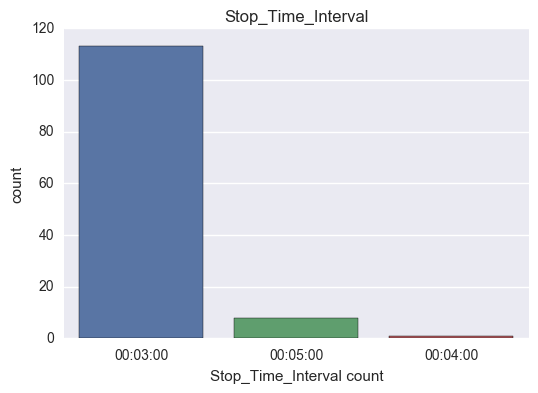

In [20]:
STI_cnt = df['Stop_Time_Interval'].value_counts()
print(STI_cnt)
sns.countplot(x='Stop_Time_Interval', data=df)
# plt.xticks(rotation=45)
plt.xlabel('Stop_Time_Interval count')
plt.title('Stop_Time_Interval')
plt.show()

In [21]:
plot_heat_map(df,'10')